## Getting coordinates and vectors of multiloops

In [3]:
from config import *
from numpy.linalg import norm

In [8]:
def get_coordinates(pdb_id, atoms=False):
    def get_index(df):
        return df.chain + "-" + df.pos

    cif = MMCIF2Dict.MMCIF2Dict(mypath("CIF_FILES", f"{pdb_id}.cif"))

    cols = [
        "_atom_site.Cartn_x",
        "_atom_site.Cartn_y",
        "_atom_site.Cartn_z",
        "_atom_site.auth_asym_id",
        "_atom_site.auth_seq_id",
        "_atom_site.auth_atom_id",
    ]
    labels = ["x", "y", "z", "chain", "pos", "atom"]

    coordinates = (
        pd.DataFrame()
        .assign(**{key: cif[key] for key in cols})
        .rename(columns={old: new for old, new in zip(cols, labels)})
        .assign(index=get_index)
        .drop(["chain", "pos"], axis=1)
        .set_index("index")
        .astype({c: float for c in ["x", "y", "z"]})
    )

    if not atoms:
        return coordinates.drop("atom", axis=1)

    return coordinates


def get_basepairs(helices):
    
    basepairs = (
        helices.groupby(level=[0, 1, 2])
        .count()
        .groupby(level=[0, 1])
        .idxmax()
        .reset_index()
        .kind.values
    )

    basepairs = pd.DataFrame(
        [x for x in basepairs], columns=["helix", "b1", "b2"]
    ).set_index("helix")
    
    return basepairs


def get_basepair_pos(coordinates, base1, base2, return_atom_pos=False):
    base_pos = [coordinates.loc[base].mean() for base in [base1, base2]]
    atom_pos = pd.concat([coordinates.loc[base] for base in [base1, base2]])
    basepair_pos = atom_pos.mean()
    if return_atom_pos:
        return atom_pos, basepair_pos
    else:
        return basepair_pos


def get_vectors(coordinates, basepairs):
    first_bp_pos = pd.DataFrame()
    first_bp_atoms = pd.DataFrame()
    helix_pos = pd.DataFrame()
    for idx in basepairs.index.unique():
        bps = basepairs.loc[idx].values
        if isinstance(bps[0], str):
            first_bp = bps
            bp = first_bp
        else:
            first_bp = bps[0]
            if len(bps) < 3:
                bp = first_bp
            else:
                bp = bps[2]
        first_bp_atom, first_bp = get_basepair_pos(
            coordinates, *first_bp, return_atom_pos=True
        )
        first_bp_pos[idx] = first_bp
        first_bp_atoms = pd.concat([first_bp_atoms, first_bp_atom])
        helix_pos[idx] = get_basepair_pos(coordinates, *bp)

    pos_df = helix_pos.assign(
        center_bps=first_bp_pos.mean(axis=1),
        center_atoms=first_bp_atoms.drop_duplicates().mean(),
    )
    vec_df = (pos_df.T - pos_df.center_atoms.values).T

    return pos_df, vec_df


def get_planar_angles(vec_df, way=3):
    angles = []
    for i in range(way):
        angle = (
            np.arccos(
                vec_df[f"helix{i+1}"].dot(vec_df[f"helix{(i+1)%4+1}"])
                / (
                    norm(vec_df[f"helix{i+1}"])
                    * norm(vec_df[f"helix{(i+1)%4+1}"])
                )
            )
            * 360
            / (2 * np.pi)
        )
        angles.append(angle)
    return angles

In [9]:
host = PdbStructure('6wru')
helices = host.ml_helices.loc[147240]

coordinates = get_coordinates('6wru', atoms=False)
basepairs = get_basepairs(helices)
_, vec_df = get_vectors(coordinates, basepairs)

angles = get_planar_angles(vec_df, way=4)

In [10]:
angles

[71.43713897747415, 132.6469526718856, 141.21576269033213, 145.70995592667293]

<AxesSubplot:xlabel='x', ylabel='y'>

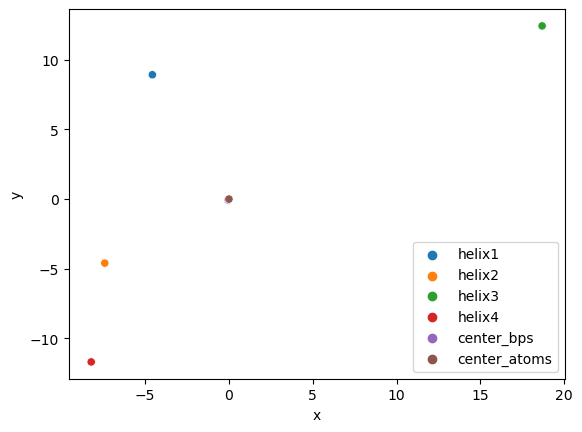

In [11]:
sns.scatterplot(x=vec_df.T['x'], y=vec_df.T['y'], hue=vec_df.T.index)

<AxesSubplot:xlabel='y', ylabel='z'>

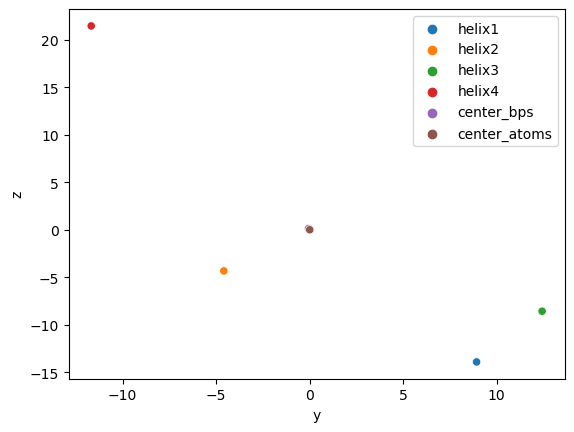

In [12]:
sns.scatterplot(x=vec_df.T['y'], y=vec_df.T['z'], hue=vec_df.T.index)